In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
import os
from skimage import color

In [17]:
def load_images_from_folder(data_dir):
    images = []
    labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)  
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                if image_file.lower().endswith('.jpg'):
                    image_path = os.path.join(label_dir, image_file)
                    img_bgr = cv2.imread(image_path)
                    if img_bgr is not None:
                        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                        images.append(img_rgb)
                        labels.append(label)
    return images, labels

data_dir = "/kaggle/input/rice-leaf-disease-image" 
    
images, labels = load_images_from_folder(data_dir)

In [18]:
unique_labels = sorted(set(labels))
label_idx = {label: idx for idx, label in enumerate(unique_labels)}

In [19]:
print("image0: ", images[0])
print("label: ", labels[0], "-- index: ", label_idx.get(labels[0]))

image0:  [[[107 162  81]
  [107 162  81]
  [108 161  79]
  ...
  [ 70 114  35]
  [ 70 114  35]
  [ 76 120  41]]

 [[103 156  74]
  [103 156  74]
  [105 157  75]
  ...
  [ 75 119  40]
  [ 75 119  40]
  [ 79 123  44]]

 [[103 153  68]
  [104 154  69]
  [105 153  69]
  ...
  [ 82 125  45]
  [ 83 126  46]
  [ 84 127  47]]

 ...

 [[ 92  89  72]
  [ 92  89  72]
  [ 90  87  70]
  ...
  [ 73  63  62]
  [ 75  65  64]
  [ 78  68  67]]

 [[ 97  91  75]
  [ 96  90  74]
  [ 95  89  73]
  ...
  [ 73  61  61]
  [ 74  62  62]
  [ 76  66  67]]

 [[ 99  93  77]
  [ 98  92  76]
  [ 97  91  75]
  ...
  [ 73  61  61]
  [ 74  62  62]
  [ 74  64  65]]]
label:  Tungro -- index:  3


In [20]:
def extract_color_features(image):
    """
    Trích xuất đặc trưng màu sắc:
    - Giá trị trung bình và độ lệch chuẩn cho mỗi kênh RGB
    - Histogram màu (được chuẩn hóa)
    """
    # Tách các kênh màu
    r, g, b = cv2.split(image)
    
    # Tính toán thống kê cho mỗi kênh
    features = []
    
    # Giá trị trung bình và độ lệch chuẩn cho mỗi kênh
    for channel in [r, g, b]:
        features.append(np.mean(channel))
        features.append(np.std(channel))
    
    # Histograms từng kênh màu (16 bins mỗi kênh)
    bins = 16
    r_hist = cv2.calcHist([r], [0], None, [bins], [0, 256])
    g_hist = cv2.calcHist([g], [0], None, [bins], [0, 256])
    b_hist = cv2.calcHist([b], [0], None, [bins], [0, 256])
    
    # Chuẩn hóa histograms
    r_hist = cv2.normalize(r_hist, r_hist).flatten()
    g_hist = cv2.normalize(g_hist, g_hist).flatten()
    b_hist = cv2.normalize(b_hist, b_hist).flatten()
    
    # Kết hợp tất cả các đặc trưng màu sắc
    features.extend(r_hist)
    features.extend(g_hist)
    features.extend(b_hist)
    
    # Chuyển sang không gian màu HSV (hữu ích cho phát hiện bệnh lá)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    
    # Tính toán thống kê cho các kênh HSV
    for channel in [h, s, v]:
        features.append(np.mean(channel))
        features.append(np.std(channel))
    
    # Histograms HSV
    h_hist = cv2.calcHist([h], [0], None, [bins], [0, 180])
    s_hist = cv2.calcHist([s], [0], None, [bins], [0, 256])
    v_hist = cv2.calcHist([v], [0], None, [bins], [0, 256])
    
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()
    
    features.extend(h_hist)
    features.extend(s_hist)
    features.extend(v_hist)
    
    return np.array(features)


color_features = extract_color_features(images[0])
color_features.shape

(108,)

In [21]:
def extract_texture_features(image):
    """
    Trích xuất đặc trưng kết cấu sử dụng:
    - Local Binary Patterns (LBP)
    - Gray Level Co-occurrence Matrix (GLCM)
    """
    # Chuyển đổi sang ảnh xám
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # LBP features
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    
    # Histogram của LBP
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    
    # GLCM features
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Trích xuất các thuộc tính từ GLCM
    glcm_features = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for prop in properties:
        glcm_features.append(graycoprops(glcm, prop).flatten())
    
    # Kết hợp các đặc trưng kết cấu
    texture_features = np.concatenate([lbp_hist, np.concatenate(glcm_features)])
    
    return texture_features

In [22]:
def extract_shape_features(image):
    """
    Trích xuất đặc trưng hình dạng sử dụng:
    - HOG (Histogram of Oriented Gradients)
    - Edge Detection and Analysis
    """
    # Chuyển đổi sang ảnh xám
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # HOG features
    resized = cv2.resize(gray, (128, 64))  # Kích thước chuẩn cho HOG
    hog_features = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
    
    # Edge detection
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
    
    # Kết hợp các đặc trưng hình dạng
    shape_features = np.append(hog_features, edge_density)
    
    return shape_features

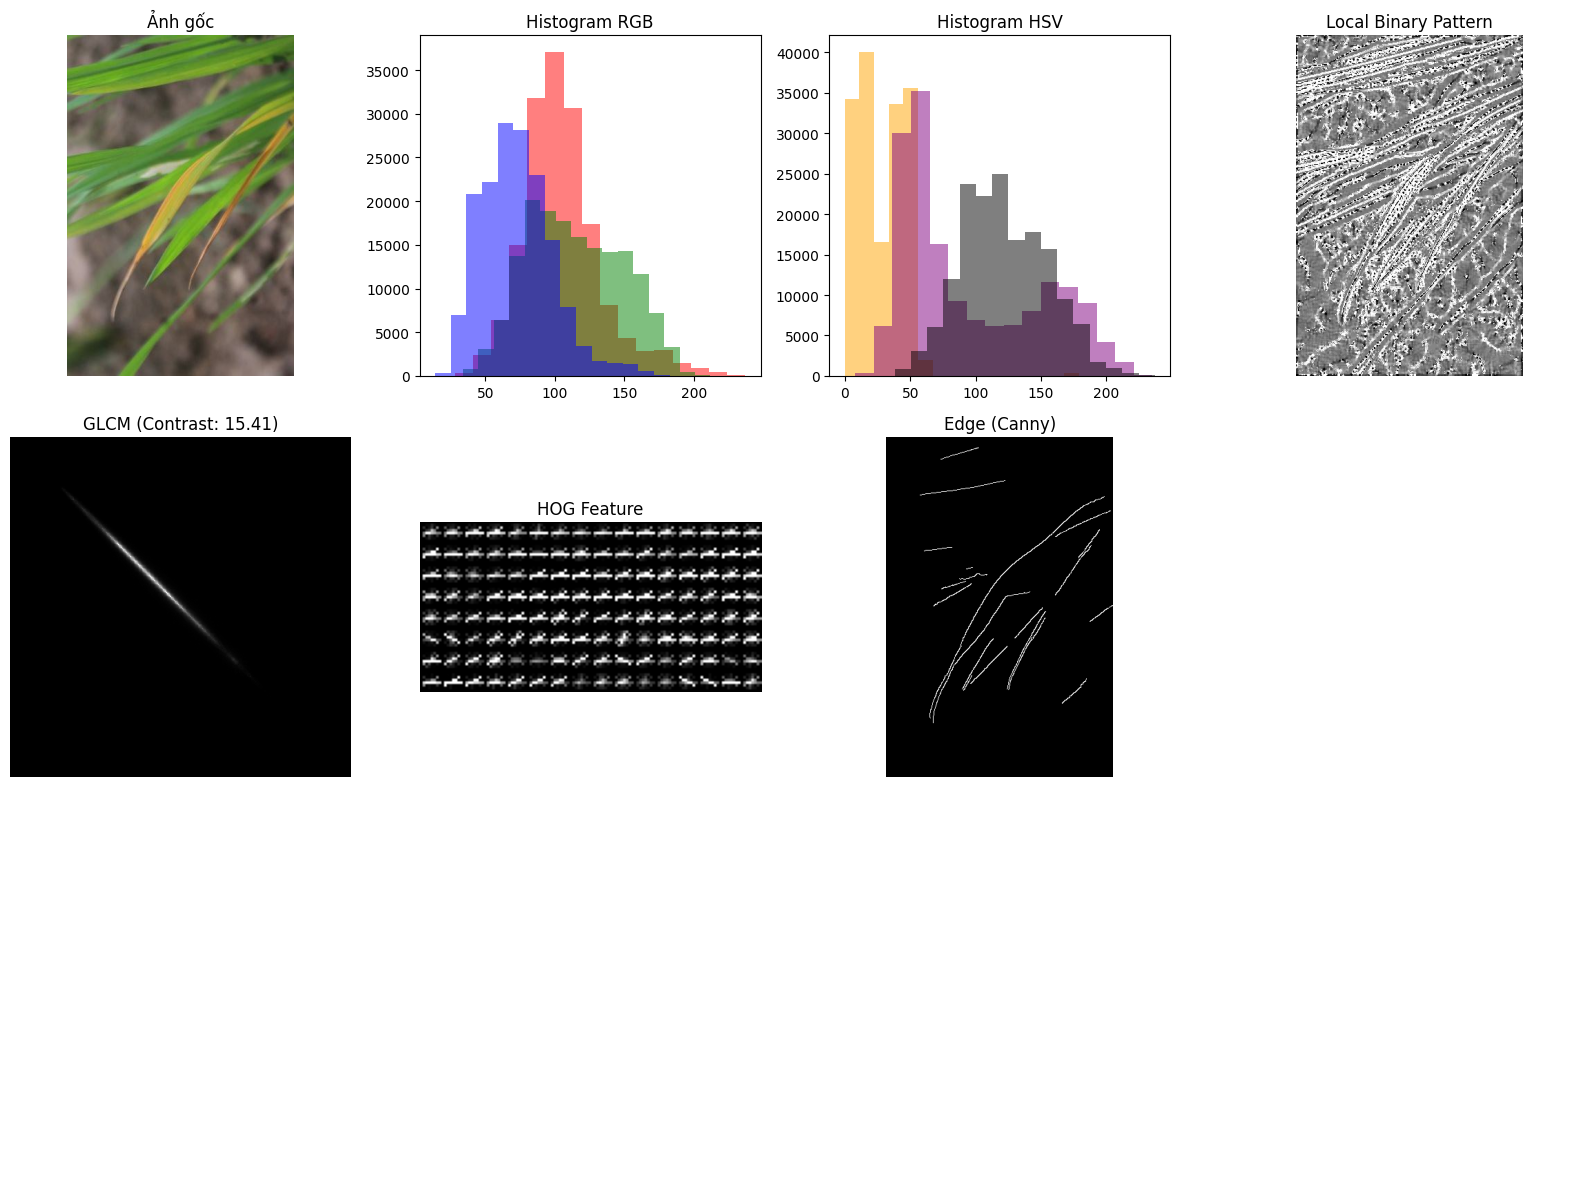

In [23]:
def visualize_features(image):
    import matplotlib.pyplot as plt
    from skimage.feature import local_binary_pattern, hog
    from skimage.color import rgb2gray
    from skimage import exposure
    from skimage.feature import graycomatrix
    import cv2
    import numpy as np

    # Ảnh RGB và xám
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # ---- MÀU SẮC ----
    r, g, b = cv2.split(image)
    h, s, v = cv2.split(hsv)

    # ---- KẾT CẤU ----
    lbp = local_binary_pattern(gray, P=24, R=3, method='uniform')
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # ---- HÌNH DẠNG ----
    resized_gray = cv2.resize(gray, (128, 64))
    hog_image = hog(resized_gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')[1]
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    edges = cv2.Canny(gray, 100, 200)

    # ---- VẼ ----
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    # Ảnh gốc
    axes[0].imshow(image)
    axes[0].set_title("Ảnh gốc")
    axes[0].axis("off")

    # Histogram RGB
    for channel, color_name in zip([r, g, b], ['red', 'green', 'blue']):
        axes[1].hist(channel.ravel(), bins=16, color=color_name, alpha=0.5)
    axes[1].set_title("Histogram RGB")

    # Histogram HSV
    for channel, color_name in zip([h, s, v], ['orange', 'purple', 'black']):
        axes[2].hist(channel.ravel(), bins=16, color=color_name, alpha=0.5)
    axes[2].set_title("Histogram HSV")

    # LBP
    axes[3].imshow(lbp, cmap='gray')
    axes[3].set_title("Local Binary Pattern")
    axes[3].axis("off")

    # GLCM - contrast
    from skimage.feature import graycoprops
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    axes[4].imshow(glcm[:, :, 0, 0], cmap='gray')
    axes[4].set_title(f"GLCM (Contrast: {contrast:.2f})")
    axes[4].axis("off")

    # HOG
    axes[5].imshow(hog_image, cmap='gray')
    axes[5].set_title("HOG Feature")
    axes[5].axis("off")

    # Edge
    axes[6].imshow(edges, cmap='gray')
    axes[6].set_title("Edge (Canny)")
    axes[6].axis("off")

    # Các ô còn lại để trống
    for i in range(7, 12):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_features(images[0])

In [42]:
def dimension_reduction(features, n_components=100):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    pca = PCA(n_components=n_components)
    features_reduced = pca.fit_transform(features_scaled)
    
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Tỷ lệ phương sai giải thích được với {n_components} thành phần: {explained_variance:.4f}")
    
    return features_reduced, scaler, pca

In [ ]:
def extract_all_features(image):
    color_features = extract_color_features(image)
    texture_features = extract_texture_features(image)
    shape_features = extract_shape_features(image)
    
    all_features = np.concatenate([color_features, texture_features, shape_features])
    
    return all_features

In [25]:
all_features = []
for img in images:
    features = extract_all_features(img)
    all_features.append(features)
    
all_features = np.array(all_features)
all_labels = np.array(labels)

In [ ]:
features_reduced, scaler, pca = dimension_reduction(all_features, n_components=600)

Tỷ lệ phương sai giải thích được với 600 thành phần: 0.9134


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        features_reduced, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )
    
    # Tìm kiếm tham số tối ưu cho SVM
print("Đang tìm kiếm tham số tối ưu cho SVM...")
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'poly']
    }
    
grid_search = GridSearchCV(
        svm.SVC(probability=True),
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
grid_search.fit(X_train, y_train)
    
best_params = grid_search.best_params_
print(f"Tham số tốt nhất: {best_params}")
    
print("Đang huấn luyện mô hình SVM cuối cùng...")
best_model = grid_search.best_estimator_
    
print("Đánh giá mô hình...")
y_pred = best_model.predict(X_test)
    
accuracy = metrics.accuracy_score(y_test, y_pred)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_report = metrics.classification_report(
        y_test, y_pred,
        target_names=list(label_idx.keys())
    )
    
print(f"Độ chính xác: {accuracy:.4f}")
print("\nMa trận nhầm lẫn:")
print(conf_matrix)
print("\nBáo cáo phân loại:")
print(class_report)

Đang tìm kiếm tham số tối ưu cho SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Tham số tốt nhất: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Đang huấn luyện mô hình SVM cuối cùng...
Đánh giá mô hình...
Độ chính xác: 0.9874

Ma trận nhầm lẫn:
[[312   1   4   0]
 [  4 284   0   0]
 [  2   0 318   0]
 [  1   3   0 258]]

Báo cáo phân loại:
                 precision    recall  f1-score   support

Bacterialblight       0.98      0.98      0.98       317
          Blast       0.99      0.99      0.99       288
      Brownspot       0.99      0.99      0.99       320
         Tungro       1.00      0.98      0.99       262

       accuracy                           0.99      1187
      macro avg       0.99      0.99      0.99      1187
   weighted avg       0.99      0.99      0.99      1187

